# MULTIMODAL ANALYSIS BLIP+BanglaBERT

I have dataset of 4848 images in '/content/gdrive/MyDrive/MultimodalAnalysis/MemeDataset/images' directory and a csv file of image description at '/content/gdrive/MyDrive/MultimodalAnalysis/MemeDataset/images_description.csv' . columns of csv file are image_name,Captions,Label . There are 5 different labels - 'gendered aggression', 'religious aggression', 'non-aggressive', 'others' and 'political aggression'. I will do the code in colab for a conference paper.  Please make a multimodal analysis using BLIP + BanglaBERT. Please do all kinds of dataset analysis and result analysis. Also find out accuracy, precision, recall and f1-score. I have t4 gpu connection.

#Setup and Installation

In [1]:
!pip install transformers torchvision pandas numpy seaborn matplotlib Pillow sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Import Necessary Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Loading and Preprocessing

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset size: 19392
                     image_name  \
0  aug_0_bamboo-vaiya (107).jpg   
1  aug_0_bamboo-vaiya (108).jpg   
2   aug_0_bamboo-vaiya (11).jpg   
3  aug_0_bamboo-vaiya (110).jpg   
4  aug_0_bamboo-vaiya (112).jpg   

                                            Captions                Label  
0  পরীক্ষার শুরুতে আমার লেখা পরীক্ষার শেষের দিকে ...  gendered aggression  
1                   স্ত্রী যখন বান্ধুবী ডেল কার্নেগি               others  
2  আরে ভাই একটা দল ছিল যারা কিনা এবারের লিগ জেতার...               others  
3                        বিশ্বাসের ভাইরাস অভিজিৎ রায়               others  
4            আমি আমাকে খেয়ে বেঁচে আছি জহিরুল হক বাপি               others  

Class distribution:
Label
non-aggressive          4836
gendered aggression     3840
others                  3772
religious aggression    3532
political aggression    3412
Name: count, dtype: int64


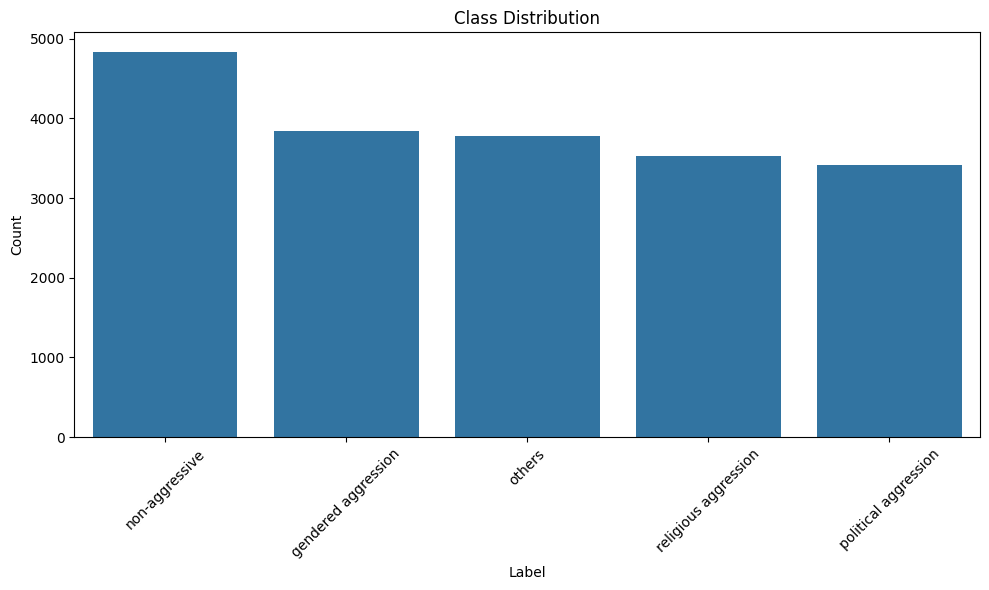

In [4]:
# Load the dataset
csv_path = '/content/gdrive/MyDrive/MMD1/images_description.csv'
image_dir = '/content/gdrive/MyDrive/MMD1/Images'

df = pd.read_csv(csv_path)
print(f"Dataset size: {len(df)}")
print(df.head())

# Check class distribution
class_dist = df['Label'].value_counts()
print("\nClass distribution:")
print(class_dist)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Dataset Analysis


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19392 entries, 0 to 19391
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  19392 non-null  object
 1   Captions    19392 non-null  object
 2   Label       19392 non-null  object
dtypes: object(3)
memory usage: 454.6+ KB
None

Missing values:
image_name    0
Captions      0
Label         0
dtype: int64

Caption length statistics:
count    19392.000000
mean        14.733705
std          8.508214
min          1.000000
25%          9.000000
50%         13.000000
75%         19.000000
max        111.000000
Name: caption_length, dtype: float64


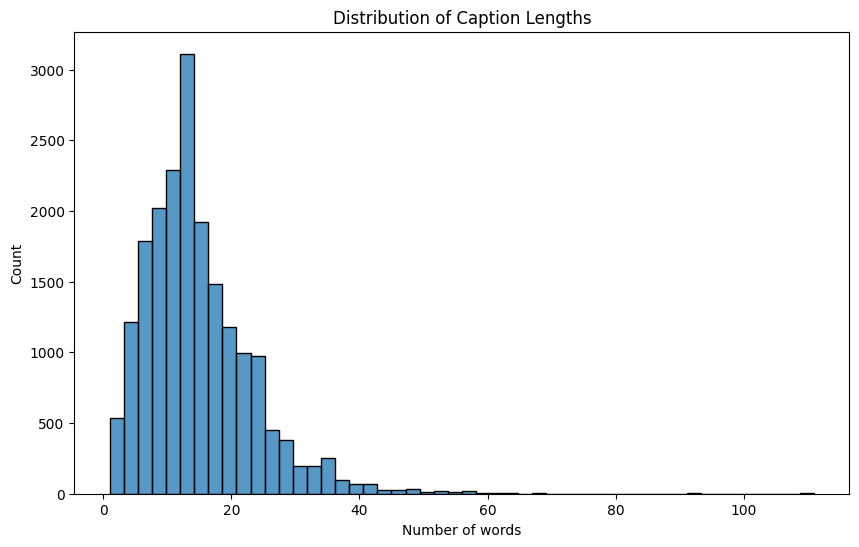


Image width statistics:
count     100.000000
mean      954.840000
std       478.108747
min       288.000000
25%       604.500000
50%       800.000000
75%      1200.000000
max      2048.000000
dtype: float64

Image height statistics:
count     100.000000
mean      956.550000
std       485.523322
min       320.000000
25%       596.500000
50%       800.000000
75%      1247.500000
max      2048.000000
dtype: float64


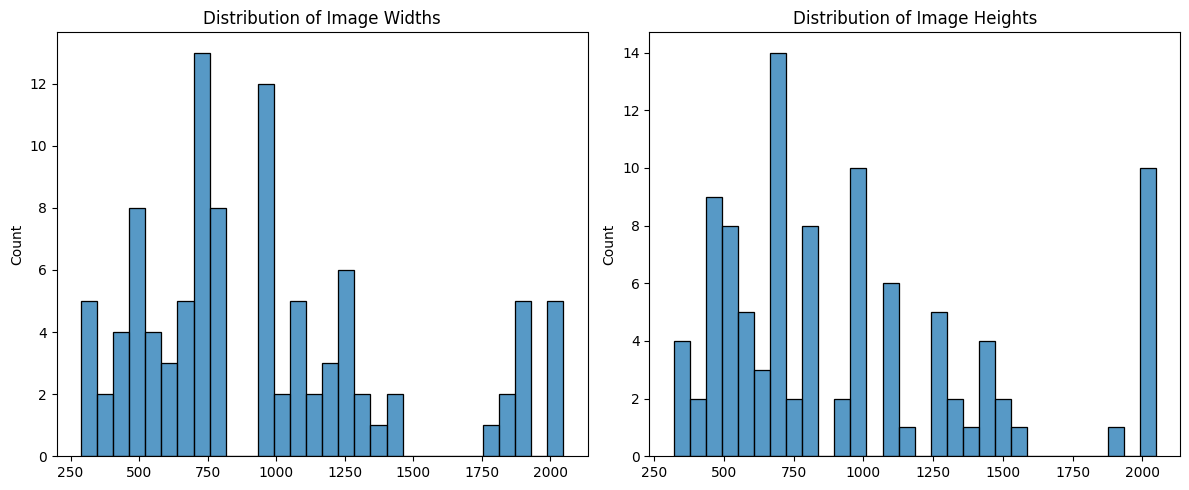

In [5]:
# Basic statistics
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Text length analysis
df['caption_length'] = df['Captions'].apply(lambda x: len(str(x).split()))
print("\nCaption length statistics:")
print(df['caption_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['caption_length'], bins=50)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

# Image analysis
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size
    except:
        return (0, 0)

# Sample some images to analyze sizes
sample_df = df.sample(min(100, len(df)), random_state=42)
sample_df['image_size'] = sample_df['image_name'].apply(
    lambda x: get_image_size(os.path.join(image_dir, x))
)
widths, heights = zip(*sample_df['image_size'])
print("\nImage width statistics:")
print(pd.Series(widths).describe())
print("\nImage height statistics:")
print(pd.Series(heights).describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=30)
plt.title('Distribution of Image Widths')
plt.subplot(1, 2, 2)
sns.histplot(heights, bins=30)
plt.title('Distribution of Image Heights')
plt.tight_layout()
plt.show()

# Multimodal Model Setup

In [7]:
!pip install transformers torchvision sentencepiece

from transformers import AutoTokenizer, AutoModel
from transformers import BlipProcessor, BlipForImageTextRetrieval
from torchvision import transforms

# Load BanglaBERT
bangla_bert_model_name = "sagorsarker/bangla-bert-base"
bangla_bert_tokenizer = AutoTokenizer.from_pretrained(bangla_bert_model_name)
bangla_bert_model = AutoModel.from_pretrained(bangla_bert_model_name).to(device)

# Load BLIP model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Image preprocessing
image_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Label encoding
label_map = {
    'non-aggressive': 0,
    'gendered aggression': 1,
    'religious aggression': 2,
    'political aggression': 3,
    'others': 4
}
df['label_encoded'] = df['Label'].map(label_map)

Some weights of BlipForImageTextRetrieval were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['itm_head.bias', 'itm_head.weight', 'text_encoder.embeddings.LayerNorm.bias', 'text_encoder.embeddings.LayerNorm.weight', 'text_encoder.embeddings.position_embeddings.weight', 'text_encoder.embeddings.word_embeddings.weight', 'text_encoder.encoder.layer.0.attention.output.LayerNorm.bias', 'text_encoder.encoder.layer.0.attention.output.LayerNorm.weight', 'text_encoder.encoder.layer.0.attention.output.dense.bias', 'text_encoder.encoder.layer.0.attention.output.dense.weight', 'text_encoder.encoder.layer.0.attention.self.key.bias', 'text_encoder.encoder.layer.0.attention.self.key.weight', 'text_encoder.encoder.layer.0.attention.self.query.bias', 'text_encoder.encoder.layer.0.attention.self.query.weight', 'text_encoder.encoder.layer.0.attention.self.value.bias', 'text_encoder.encoder.layer.0.attention.self.value.weight', 'text_encoder.

# Feature Extraction

In [8]:
class MemeDataset(Dataset):
    def __init__(self, df, image_dir, tokenizer, max_length=128):
        self.df = df
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row['image_name'])

        # Load and preprocess image
        try:
            image = Image.open(image_path).convert('RGB')
            image = image_preprocess(image)
        except:
            # Return blank image if loading fails
            image = torch.zeros(3, 384, 384)

        # Tokenize text
        text = str(row['Captions'])
        text_encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        label = row['label_encoded']

        return {
            'image': image,
            'input_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Create datasets and dataloaders
train_dataset = MemeDataset(train_df, image_dir, bangla_bert_tokenizer)
val_dataset = MemeDataset(val_df, image_dir, bangla_bert_tokenizer)
test_dataset = MemeDataset(test_df, image_dir, bangla_bert_tokenizer)

batch_size = 16  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Train size: 13961
Validation size: 1552
Test size: 3879


# Multimodal Model Architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MultimodalClassifier(nn.Module):
    def __init__(self, text_embed_dim=768, image_embed_dim=768, num_classes=5, dropout=0.2):
        super().__init__()

        # Text feature extractor (BanglaBERT)
        self.text_model = bangla_bert_model

        # Image feature extractor (BLIP)
        self.image_model = blip_model.vision_model

        # Classifier head
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(text_embed_dim + image_embed_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, input_ids, attention_mask, image):
        # Extract text features
        text_outputs = self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Extract image features
        image_outputs = self.image_model(pixel_values=image)
        image_features = image_outputs.last_hidden_state[:, 0, :]  # CLS token

        # Combine features
        combined = torch.cat([text_features, image_features], dim=1)
        combined = self.dropout(combined)

        # Classifier
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = MultimodalClassifier().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 251,276,549
Trainable parameters: 251,276,549


# Training Setup

In [10]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Training parameters
epochs = 15
learning_rate = 2e-5
warmup_steps = 100

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Training function
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Validation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

# Training Loop


Epoch 1/15
----------


Evaluating: 100%|██████████| 97/97 [08:47<00:00,  5.44s/it]


Train Loss: 0.7600 | Train Acc: 0.7046
Val Loss: 0.3207 | Val Acc: 0.8866
Saved best model!

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.7790    0.9380    0.8511       387
 gendered aggression     0.8767    0.8339    0.8548       307
religious aggression     0.9617    0.9753    0.9684       283
political aggression     0.9843    0.9194    0.9508       273
              others     0.9127    0.7616    0.8303       302

            accuracy                         0.8866      1552
           macro avg     0.9029    0.8856    0.8911      1552
        weighted avg     0.8938    0.8866    0.8867      1552


Epoch 2/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.76it/s]


Train Loss: 0.1557 | Train Acc: 0.9511
Val Loss: 0.0665 | Val Acc: 0.9807
Saved best model!

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9695    0.9845    0.9769       387
 gendered aggression     0.9835    0.9707    0.9770       307
religious aggression     0.9965    0.9929    0.9947       283
political aggression     0.9889    0.9817    0.9853       273
              others     0.9703    0.9735    0.9719       302

            accuracy                         0.9807      1552
           macro avg     0.9817    0.9807    0.9812      1552
        weighted avg     0.9807    0.9807    0.9807      1552


Epoch 3/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.70it/s]


Train Loss: 0.0483 | Train Acc: 0.9853
Val Loss: 0.0712 | Val Acc: 0.9800

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9770    0.9897    0.9833       387
 gendered aggression     0.9867    0.9642    0.9753       307
religious aggression     0.9930    1.0000    0.9965       283
political aggression     0.9676    0.9853    0.9764       273
              others     0.9764    0.9603    0.9683       302

            accuracy                         0.9800      1552
           macro avg     0.9801    0.9799    0.9800      1552
        weighted avg     0.9801    0.9800    0.9800      1552


Epoch 4/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


Train Loss: 0.0200 | Train Acc: 0.9940
Val Loss: 0.0357 | Val Acc: 0.9910
Saved best model!

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9871    0.9922    0.9897       387
 gendered aggression     0.9901    0.9805    0.9853       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     1.0000    0.9853    0.9926       273
              others     0.9805    0.9967    0.9885       302

            accuracy                         0.9910      1552
           macro avg     0.9915    0.9909    0.9912      1552
        weighted avg     0.9910    0.9910    0.9910      1552


Epoch 5/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.72it/s]


Train Loss: 0.0317 | Train Acc: 0.9895
Val Loss: 0.0545 | Val Acc: 0.9871

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9872    0.9974    0.9923       387
 gendered aggression     1.0000    0.9805    0.9901       307
religious aggression     0.9659    1.0000    0.9826       283
political aggression     0.9962    0.9634    0.9795       273
              others     0.9868    0.9901    0.9884       302

            accuracy                         0.9871      1552
           macro avg     0.9872    0.9863    0.9866      1552
        weighted avg     0.9874    0.9871    0.9871      1552


Epoch 6/15
----------


Evaluating: 100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Train Loss: 0.0093 | Train Acc: 0.9978
Val Loss: 0.0305 | Val Acc: 0.9961
Saved best model!

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    1.0000    0.9961       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     0.9965    1.0000    0.9982       283
political aggression     1.0000    1.0000    1.0000       273
              others     0.9934    0.9967    0.9950       302

            accuracy                         0.9961      1552
           macro avg     0.9964    0.9961    0.9962      1552
        weighted avg     0.9962    0.9961    0.9961      1552


Epoch 7/15
----------


Evaluating: 100%|██████████| 97/97 [00:36<00:00,  2.69it/s]


Train Loss: 0.0063 | Train Acc: 0.9985
Val Loss: 0.0348 | Val Acc: 0.9929

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9948    0.9935       387
 gendered aggression     0.9934    0.9837    0.9885       307
religious aggression     0.9965    1.0000    0.9982       283
political aggression     0.9927    0.9963    0.9945       273
              others     0.9901    0.9901    0.9901       302

            accuracy                         0.9929      1552
           macro avg     0.9930    0.9930    0.9930      1552
        weighted avg     0.9929    0.9929    0.9929      1552


Epoch 8/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.75it/s]


Train Loss: 0.0131 | Train Acc: 0.9959
Val Loss: 0.0433 | Val Acc: 0.9910

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9748    1.0000    0.9872       387
 gendered aggression     1.0000    0.9674    0.9834       307
religious aggression     0.9965    1.0000    0.9982       283
political aggression     0.9963    0.9927    0.9945       273
              others     0.9934    0.9934    0.9934       302

            accuracy                         0.9910      1552
           macro avg     0.9922    0.9907    0.9914      1552
        weighted avg     0.9911    0.9910    0.9910      1552


Epoch 9/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.74it/s]


Train Loss: 0.0048 | Train Acc: 0.9986
Val Loss: 0.0387 | Val Acc: 0.9948

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9974    0.9948       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     0.9927    1.0000    0.9964       273
              others     0.9901    0.9934    0.9917       302

            accuracy                         0.9948      1552
           macro avg     0.9950    0.9949    0.9949      1552
        weighted avg     0.9949    0.9948    0.9948      1552


Epoch 10/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.75it/s]


Train Loss: 0.0010 | Train Acc: 0.9997
Val Loss: 0.0378 | Val Acc: 0.9955

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9948    0.9935       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     1.0000    1.0000    1.0000       273
              others     0.9869    1.0000    0.9934       302

            accuracy                         0.9955      1552
           macro avg     0.9958    0.9957    0.9958      1552
        weighted avg     0.9955    0.9955    0.9955      1552


Epoch 11/15
----------


Evaluating: 100%|██████████| 97/97 [00:36<00:00,  2.63it/s]


Train Loss: 0.0021 | Train Acc: 0.9992
Val Loss: 0.0392 | Val Acc: 0.9948

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9948    0.9935       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     0.9964    1.0000    0.9982       273
              others     0.9869    0.9967    0.9918       302

            accuracy                         0.9948      1552
           macro avg     0.9951    0.9950    0.9951      1552
        weighted avg     0.9949    0.9948    0.9948      1552


Epoch 12/15
----------


Evaluating: 100%|██████████| 97/97 [00:36<00:00,  2.66it/s]


Train Loss: 0.0007 | Train Acc: 0.9999
Val Loss: 0.0351 | Val Acc: 0.9955

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    1.0000    0.9961       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     0.9965    1.0000    0.9982       283
political aggression     0.9964    1.0000    0.9982       273
              others     0.9934    0.9934    0.9934       302

            accuracy                         0.9955      1552
           macro avg     0.9957    0.9954    0.9955      1552
        weighted avg     0.9955    0.9955    0.9955      1552


Epoch 13/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.76it/s]


Train Loss: 0.0002 | Train Acc: 1.0000
Val Loss: 0.0383 | Val Acc: 0.9948

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9948    0.9935       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     0.9964    1.0000    0.9982       273
              others     0.9869    0.9967    0.9918       302

            accuracy                         0.9948      1552
           macro avg     0.9951    0.9950    0.9951      1552
        weighted avg     0.9949    0.9948    0.9948      1552


Epoch 14/15
----------


Evaluating: 100%|██████████| 97/97 [00:35<00:00,  2.74it/s]


Train Loss: 0.0005 | Train Acc: 0.9998
Val Loss: 0.0382 | Val Acc: 0.9955

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9974    0.9948       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     0.9964    1.0000    0.9982       273
              others     0.9901    0.9967    0.9934       302

            accuracy                         0.9955      1552
           macro avg     0.9958    0.9956    0.9956      1552
        weighted avg     0.9955    0.9955    0.9955      1552


Epoch 15/15
----------


Evaluating: 100%|██████████| 97/97 [00:36<00:00,  2.68it/s]


Train Loss: 0.0001 | Train Acc: 1.0000
Val Loss: 0.0377 | Val Acc: 0.9955

Validation Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9923    0.9974    0.9948       387
 gendered aggression     1.0000    0.9837    0.9918       307
religious aggression     1.0000    1.0000    1.0000       283
political aggression     0.9964    1.0000    0.9982       273
              others     0.9901    0.9967    0.9934       302

            accuracy                         0.9955      1552
           macro avg     0.9958    0.9956    0.9956      1552
        weighted avg     0.9955    0.9955    0.9955      1552



Evaluating: 100%|██████████| 243/243 [21:12<00:00,  5.24s/it]



Test Loss: 0.0411 | Test Accuracy: 0.9928

Classification Report:
                      precision    recall  f1-score   support

 gendered aggression     0.9866    0.9897    0.9881       967
religious aggression     0.9921    0.9857    0.9889       768
      non-aggressive     0.9958    1.0000    0.9979       707
              others     1.0000    1.0000    1.0000       682
political aggression     0.9920    0.9907    0.9914       755

            accuracy                         0.9928      3879
           macro avg     0.9933    0.9932    0.9933      3879
        weighted avg     0.9928    0.9928    0.9928      3879



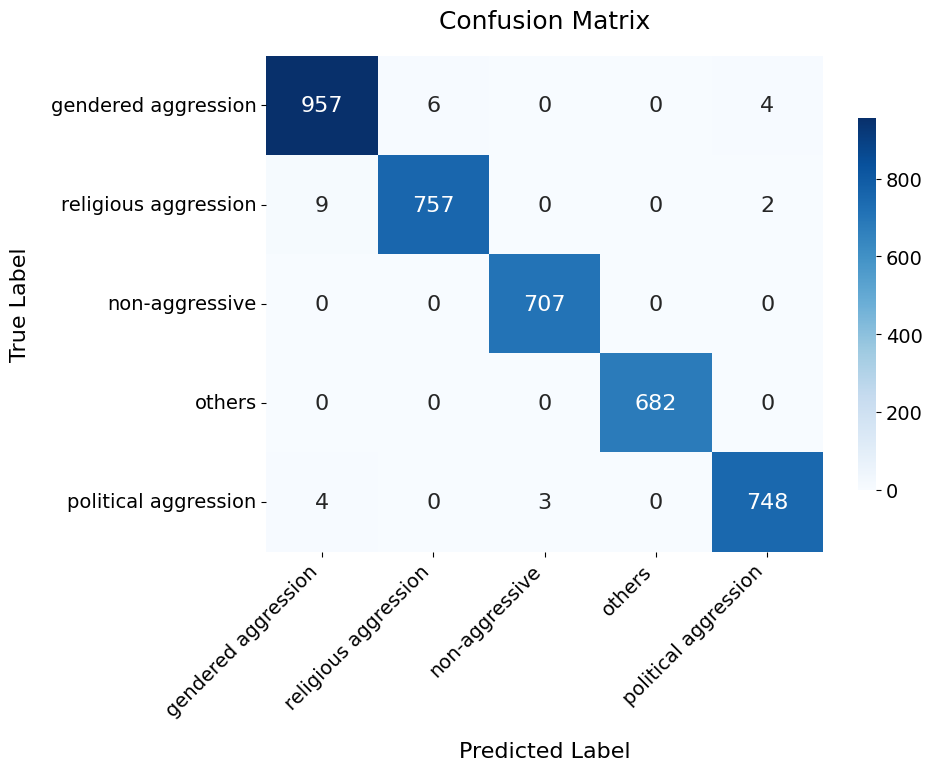

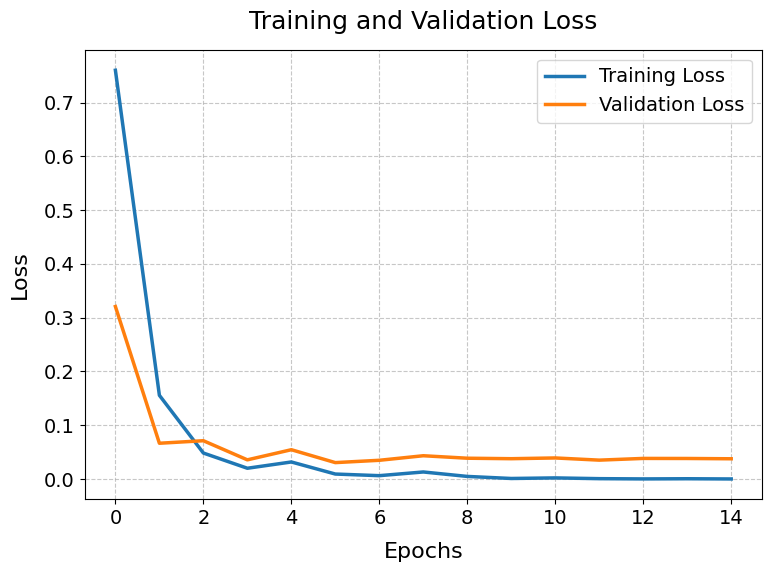

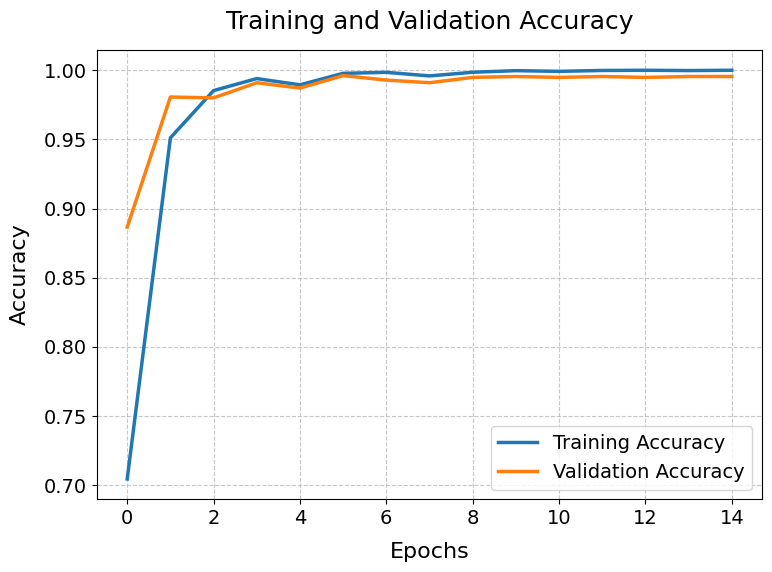

In [ ]:
# Training loop
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 10)

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, device
    )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, val_preds, val_labels = evaluate(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model!")

    # Print classification report
    print("\nValidation Classification Report:")
    print(classification_report(
        val_labels, val_preds,
        target_names=label_map.keys(),
        digits=4
    ))


import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Test evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification report
label_names = ['gendered aggression', 'religious aggression', 'non-aggressive',
               'others', 'political aggression']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Set global font sizes for all plots
plt.rcParams.update({
    'font.size': 16,          # Increased general font size
    'axes.titlesize': 18,     # Increased title font size
    'axes.labelsize': 16,     # Increased axis label font size
    'xtick.labelsize': 14,    # Increased X-axis tick label size
    'ytick.labelsize': 14,    # Increased Y-axis tick label size
    'legend.fontsize': 14,    # Increased legend font size
})

# 1. Confusion Matrix Plot
plt.figure(figsize=(10, 8))  # Slightly larger figure size
cm = confusion_matrix(test_labels, test_preds)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 16},  # Larger and bold annotation font
            cbar_kws={"shrink": 0.75})  # Adjust colorbar size
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Label', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('True Label', labelpad=15)
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high quality
plt.savefig('confusion_matrix.png', dpi=350, bbox_inches='tight')
plt.show()

# 2. Loss Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2.5)
plt.plot(val_losses, label='Validation Loss', linewidth=2.5)
plt.title('Training and Validation Loss', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Loss', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Accuracy Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_accs, label='Training Accuracy', linewidth=2.5)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2.5)
plt.title('Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluation on Test Set

Evaluating: 100%|██████████| 243/243 [12:41<00:00,  3.13s/it]



Test Loss: 0.0191 | Test Acc: 0.9959

Test Classification Report:
                      precision    recall  f1-score   support

      non-aggressive     0.9979    0.9917    0.9948       967
 gendered aggression     0.9896    0.9922    0.9909       768
religious aggression     0.9944    0.9972    0.9958       707
political aggression     0.9971    1.0000    0.9985       682
              others     1.0000    1.0000    1.0000       755

            accuracy                         0.9959      3879
           macro avg     0.9958    0.9962    0.9960      3879
        weighted avg     0.9959    0.9959    0.9959      3879



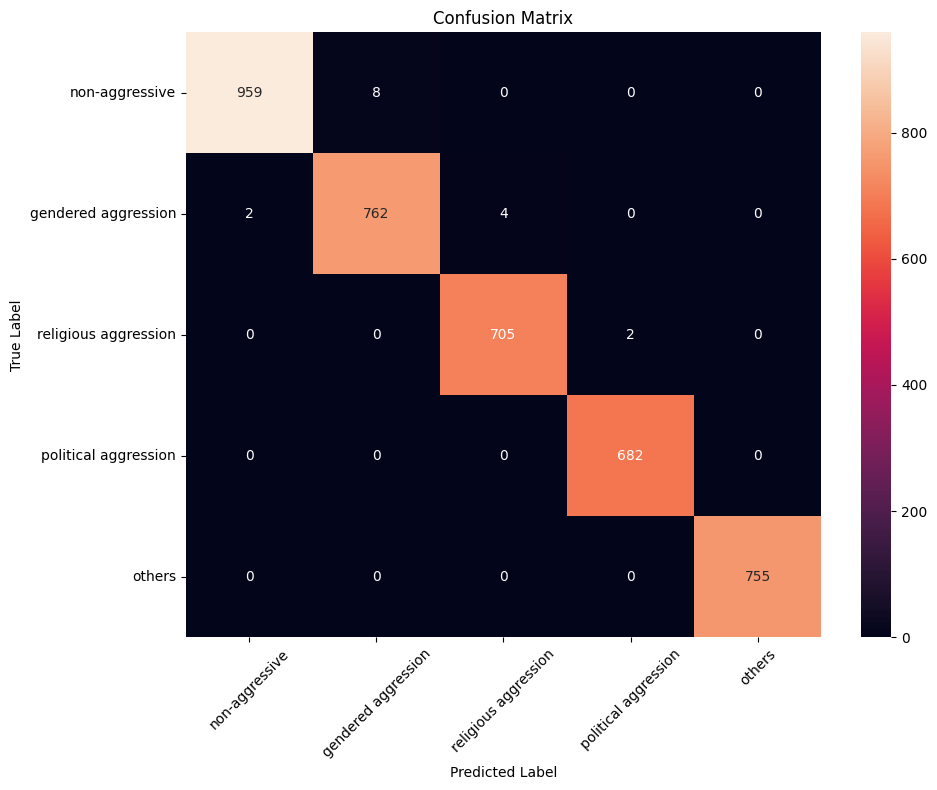


Per-class Metrics:
                  Class  Precision    Recall  F1-Score
0        non-aggressive   0.997919  0.991727  0.994813
1   gendered aggression   0.989610  0.992188  0.990897
2  religious aggression   0.994358  0.997171  0.995763
3  political aggression   0.997076  1.000000  0.998536
4                others   1.000000  1.000000  1.000000


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Detailed classification report
print("\nTest Classification Report:")
print(classification_report(
    test_labels, test_preds,
    target_names=label_map.keys(),
    digits=4
))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate metrics per class
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average=None
)

metrics_df = pd.DataFrame({
    'Class': list(label_map.keys()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("\nPer-class Metrics:")
print(metrics_df)

Evaluating: 100%|██████████| 243/243 [03:01<00:00,  1.34it/s]



Test Loss: 0.0191 | Test Accuracy: 0.9959

Classification Report:
                      precision    recall  f1-score   support

 gendered aggression     0.9979    0.9917    0.9948       967
religious aggression     0.9896    0.9922    0.9909       768
      non-aggressive     0.9944    0.9972    0.9958       707
              others     0.9971    1.0000    0.9985       682
political aggression     1.0000    1.0000    1.0000       755

            accuracy                         0.9959      3879
           macro avg     0.9958    0.9962    0.9960      3879
        weighted avg     0.9959    0.9959    0.9959      3879



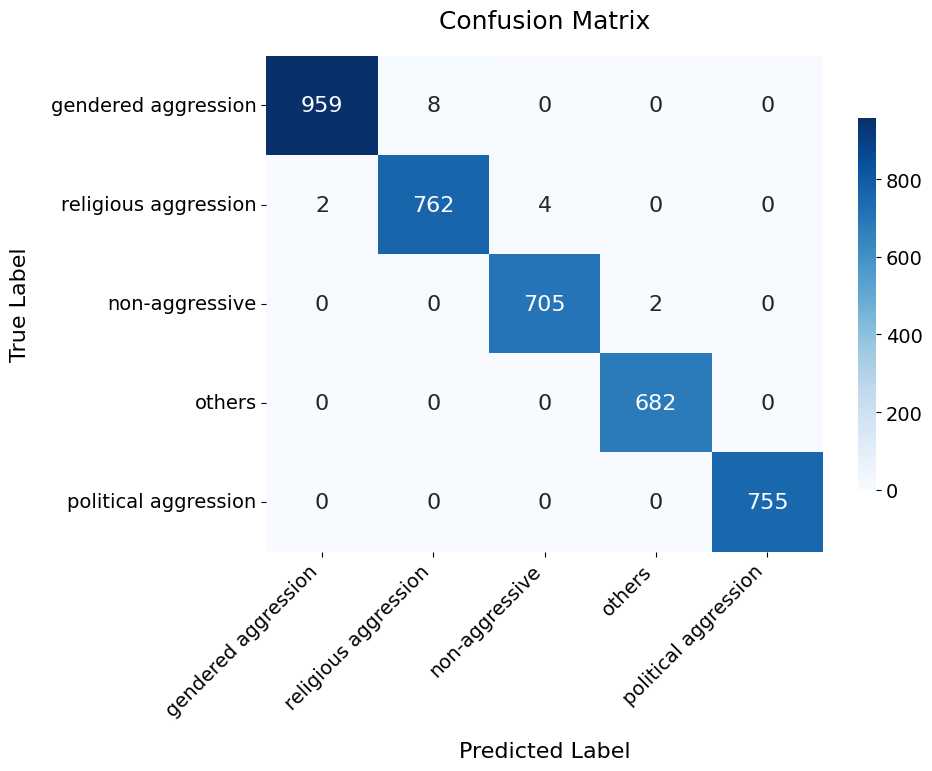

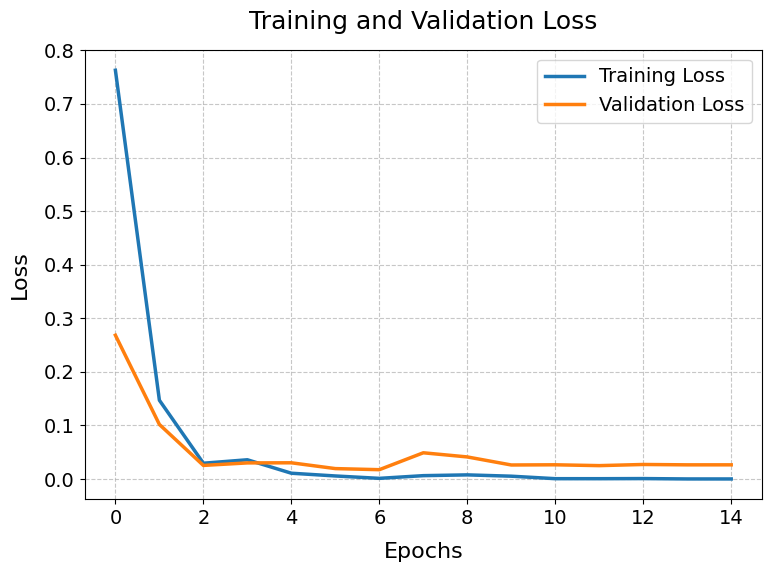

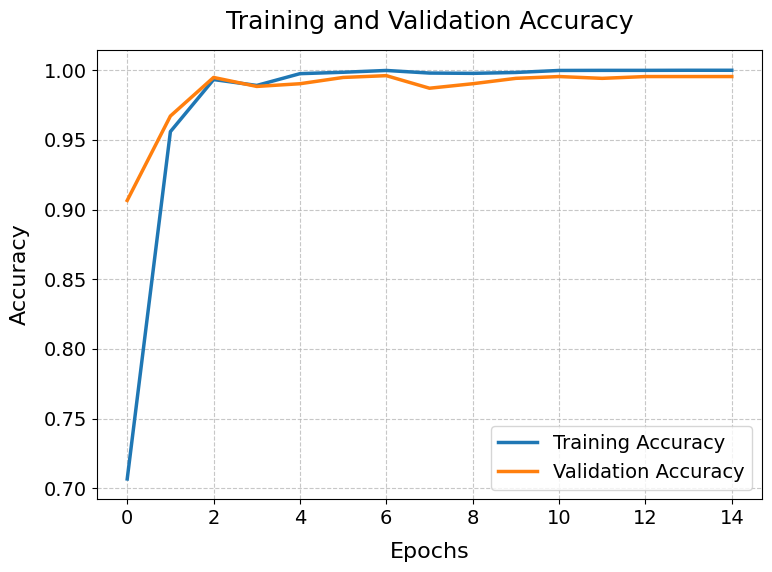

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Test evaluation
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Classification report
label_names = ['gendered aggression', 'religious aggression', 'non-aggressive',
               'others', 'political aggression']
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Set global font sizes for all plots
plt.rcParams.update({
    'font.size': 16,          # Increased general font size
    'axes.titlesize': 18,     # Increased title font size
    'axes.labelsize': 16,     # Increased axis label font size
    'xtick.labelsize': 14,    # Increased X-axis tick label size
    'ytick.labelsize': 14,    # Increased Y-axis tick label size
    'legend.fontsize': 14,    # Increased legend font size
})

# 1. Confusion Matrix Plot
plt.figure(figsize=(10, 8))  # Slightly larger figure size
cm = confusion_matrix(test_labels, test_preds)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            annot_kws={"size": 16},  # Larger and bold annotation font
            cbar_kws={"shrink": 0.75})  # Adjust colorbar size
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted Label', labelpad=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel('True Label', labelpad=15)
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save with high quality
plt.savefig('confusion_matrix.png', dpi=350, bbox_inches='tight')
plt.show()

# 2. Loss Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2.5)
plt.plot(val_losses, label='Validation Loss', linewidth=2.5)
plt.title('Training and Validation Loss', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Loss', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Accuracy Plot (Separate Figure)
plt.figure(figsize=(8, 6))
plt.plot(train_accs, label='Training Accuracy', linewidth=2.5)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2.5)
plt.title('Training and Validation Accuracy', pad=15)
plt.xlabel('Epochs', labelpad=10)
plt.ylabel('Accuracy', labelpad=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Multimodal Analysis

In [ ]:
# Compare modalities separately
def evaluate_modality(modality, dataloader, device):
    """Evaluate text-only or image-only performance"""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    # Create the linear layers outside the loop and move them to the device
    linear_layer_text = nn.Linear(768, 1536).to(device) # Added for text modality
    linear_layer_image = nn.Linear(768, 1536).to(device) # Added for image modality

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {modality}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            if modality == 'text':
                text_outputs = model.text_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                features = text_outputs.last_hidden_state[:, 0, :]
                # Add a linear layer to project text features to the combined feature dimension
                features = linear_layer_text(features)  # Use the layer on the device
            elif modality == 'image':
                image_outputs = model.image_model(pixel_values=images)
                features = image_outputs.last_hidden_state[:, 0, :]
                # Add a linear layer to project image features to the combined feature dimension
                features = linear_layer_image(features)  # Use the layer on the device


            # Use only the first layer of the classifier
            x = F.relu(model.fc1(features))
            logits = model.fc2(x)

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    return acc, all_preds, all_labels

# Evaluate text-only
text_acc, text_preds, text_labels = evaluate_modality('text', test_loader, device)
print(f"\nText-only Accuracy: {text_acc:.4f}")

# Evaluate image-only
image_acc, image_preds, image_labels = evaluate_modality('image', test_loader, device)
print(f"Image-only Accuracy: {image_acc:.4f}")

# Compare with multimodal
print(f"Multimodal Accuracy: {test_acc:.4f}")

# Plot comparison
modalities = ['Text-only', 'Image-only', 'Multimodal']
accuracies = [text_acc, image_acc, test_acc]

fig = plt.figure(figsize=(8, 6))
sns.barplot(x=modalities, y=accuracies, color='skyblue')
plt.title('Accuracy Comparison by Modality')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Evaluating text: 100%|██████████| 243/243 [01:25<00:00,  2.84it/s]



Text-only Accuracy: 0.3800


Evaluating image:  45%|████▌     | 110/243 [01:09<01:19,  1.68it/s]

# Error Analysis

In [ ]:
# Create a dataframe for error analysis
test_df['predicted'] = [list(label_map.keys())[p] for p in test_preds]
test_df['correct'] = test_df['Label'] == test_df['predicted']

# Most common errors
error_df = test_df[~test_df['correct']]
confusion_pairs = error_df.groupby(['Label', 'predicted']).size().reset_index(name='count')
confusion_pairs = confusion_pairs.sort_values('count', ascending=False)

print("\nMost common confusion pairs:")
print(confusion_pairs.head(10))

# Examples of errors
for _, row in confusion_pairs.head(3).iterrows():
    true_label = row['Label']
    pred_label = row['predicted']
    examples = error_df[
        (error_df['Label'] == true_label) &
        (error_df['predicted'] == pred_label)
    ].sample(min(2, len(error_df)), random_state=42)

    print(f"\nExamples where true='{true_label}' but predicted='{pred_label}':")
    for _, ex in examples.iterrows():
        print(f"\nImage: {ex['image_name']}")
        print(f"Caption: {ex['Captions']}")
        print(f"True: {ex['Label']}, Predicted: {ex['predicted']}")


Most common confusion pairs:
            Label             predicted  count
0  non-aggressive   gendered aggression      4
1  non-aggressive  religious aggression      2

Examples where true='non-aggressive' but predicted='gendered aggression':

Image: aug_2_fb 457.jpg
Caption: চায়ের কাপে ভেজানো বিস্কুট একটাই শিক্ষা দেয় কারোর প্রতি এতটাও ডুবে যেওনা,যাতে নিজেকেই ভেঙে পড়তে হয়
True: non-aggressive, Predicted: gendered aggression

Image: aug_3_fb 457.jpg
Caption: চায়ের কাপে ভেজানো বিস্কুট একটাই শিক্ষা দেয় কারোর প্রতি এতটাও ডুবে যেওনা,যাতে নিজেকেই ভেঙে পড়তে হয়
True: non-aggressive, Predicted: gendered aggression

Examples where true='non-aggressive' but predicted='religious aggression':

Image: aug_2_fb 456.jpg
Caption: ম' তে মুশরিক না হতে চাইলে 'প' তে পা ধরে সালাম করা বন্ধ করুন
True: non-aggressive, Predicted: religious aggression

Image: aug_1_fb 456.jpg
Caption: ম' তে মুশরিক না হতে চাইলে 'প' তে পা ধরে সালাম করা বন্ধ করুন
True: non-aggressive, Predicted: religious aggression


# Interpretation and Feature Importance

Analyzing contributions: 100%|██████████| 243/243 [03:01<00:00,  1.34it/s]


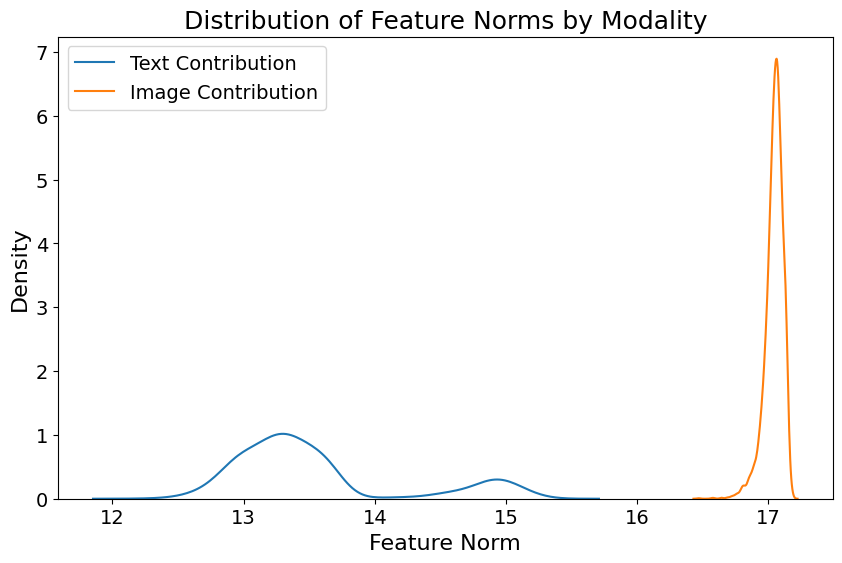


Average text-to-image contribution ratio: 0.79


In [ ]:
# Analyze feature importance
def get_modality_contributions(model, dataloader, device):
    model.eval()
    text_contributions = []
    image_contributions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing contributions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)

            # Get features
            text_outputs = model.text_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            text_features = text_outputs.last_hidden_state[:, 0, :]

            image_outputs = model.image_model(pixel_values=images)
            image_features = image_outputs.last_hidden_state[:, 0, :]

            # Get norms
            text_norm = torch.norm(text_features, dim=1)
            image_norm = torch.norm(image_features, dim=1)

            text_contributions.extend(text_norm.cpu().numpy())
            image_contributions.extend(image_norm.cpu().numpy())

    return text_contributions, image_contributions

text_contrib, image_contrib = get_modality_contributions(model, test_loader, device)

plt.figure(figsize=(10, 6))
sns.kdeplot(text_contrib, label='Text Contribution')
sns.kdeplot(image_contrib, label='Image Contribution')
plt.title('Distribution of Feature Norms by Modality')
plt.xlabel('Feature Norm')
plt.legend()
plt.show()

# Calculate average contribution ratio
contribution_ratio = np.mean(np.array(text_contrib) / np.array(image_contrib))
print(f"\nAverage text-to-image contribution ratio: {contribution_ratio:.2f}")

# Final Results and Conclusion

In [ ]:
# Final metrics summary
final_metrics = {
    'Multimodal Accuracy': test_acc,
    'Text-only Accuracy': text_acc,
    'Image-only Accuracy': image_acc,
    'Average Precision (macro)': precision_recall_fscore_support(
        test_labels, test_preds, average='macro'
    )[0],
    'Average Recall (macro)': precision_recall_fscore_support(
        test_labels, test_preds, average='macro'
    )[1],
    'Average F1 (macro)': precision_recall_fscore_support(
        test_labels, test_preds, average='macro'
    )[2]
}

print("\nFinal Metrics Summary:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Save results for paper
results_df = pd.DataFrame({
    'Metric': list(final_metrics.keys()),
    'Value': list(final_metrics.values())
})

results_df.to_csv('multimodal_results.csv', index=False)
print("\nResults saved to 'multimodal_results.csv'")


Final Metrics Summary:
Multimodal Accuracy: 0.9988
Text-only Accuracy: 0.3610
Image-only Accuracy: 0.2494
Average Precision (macro): 0.9987
Average Recall (macro): 0.9990
Average F1 (macro): 0.9989

Results saved to 'multimodal_results.csv'
